# Classification and Auto-Tagging of Stack Exchange Questions

**[Problem posed by Kaggle](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags):** Predict tags from models trained on unrelated topics.

*"What does physics have in common with **_biology, cooking, cryptography, diy, robotics, and travel?_** If you answered "all pursuits are governed by the immutable laws of physics" we'll begrudgingly give you partial credit. If you answered "all were chosen randomly by a scheming Kaggle employee for a twisted transfer learning competition", congratulations, we accept your answer and mark the question as solved.*

*In this competition, we provide the titles, text, and tags of Stack Exchange questions from six different sites. We then ask for tag predictions on unseen physics questions. Solving this problem via a standard machine approach might involve training an algorithm on a corpus of related text. Here, you are challenged to train on material from outside the field. Can an algorithm learn appropriate physics tags from "extreme-tourism Antarctica"? Let's find out."*

## Phase 1: EDA

In [198]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load in some preprocessed data with pickle

In [223]:
balanced_classes_file = open("pickle_jar/dataframes/classify_Stopwords_3xTitle_ner_stripPunct_dataframe.p", 'rb')
balanced_classes_data = pickle.load(balanced_classes_file)

balanced_classes_tag_counter_file = open('pickle_jar/tag_counters/classify_Stopwords_3xTitle_ner_stripPunct_tag_counts.p', 'rb')
balanced_classes_tag_counter = pickle.load(balanced_classes_tag_counter_file)

balanced_classes_bow_counter_file = open('pickle_jar/post_counters/classify_Stopwords_3xTitle_ner_stripPunct_token_counts.p', 'rb')
balanced_classes_bow_counter = pickle.load(balanced_classes_bow_counter_file)


thread_dict = {'biology':0,'cooking':1,'crypto':2,'diy':3,'robotics':4,'travel':5}
balanced_classes_data['thread_ids'] = balanced_classes_data.thread.apply(lambda x: thread_dict[x]).values

In [9]:
balanced_classes_data.T.iloc[:,:3]

,0,1,2
id,1,2,3
title,What is the criticality of the ribosome bindin...,How is RNAse contamination in RNA based experi...,Are lymphocyte sizes clustered in two groups?
content,"<p>In prokaryotic translation, how critical fo...",<p>Does anyone have any suggestions to prevent...,<p>Tortora writes in <em>Principles of Anatomy...
tags,"[b, ribosome, binding, sites, translation, syn...","[b, rna, biochemistry]","[b, immunology, cell, biology, hematology]"
thread,biology,biology,biology
ttl_ctxt,What is the criticality of the ribosome bindin...,How is RNAse contamination in RNA based experi...,Are lymphocyte sizes clustered in two groups?<...
tokens,b'what is the criticality of the ribosome bind...,b'how is rnase contamination in rna based expe...,b'are lymphocyte sizes clustered in TWO groups...


### Lets check out some posts

In [384]:
def view_example_post(index):
    print("QUESTION:\n{}\n".format(balanced_classes_data['title'].iloc[index]))

    print("ELABORATION:\n{}\n".format(balanced_classes_data['content'].iloc[index]))

    print("TAGS:\n{}\n".format(balanced_classes_data['tags'].iloc[index]))

    print("CLASS: ***{}***".format(balanced_classes_data['thread'].iloc[index]))

view_example_post(np.random.randint(0,len(balanced_classes_data)))

QUESTION:
Is it safe to encrypt a public key alongside a message with AES?

ELABORATION:
<p>If I have a message M and a public key P, and I encrypt them alongside one another:</p>

<pre><code>CIPHER = AES(M + P, aes_key)
</code></pre>

<p>Is CIPHER now weakened if someone knows what P is? It seems like if I encrypted only P:</p>

<pre><code>CIPHER = AES(P, aes_key)
</code></pre>

<p>that it should be possible to recover aes_key from CIPHER. I realize that this is different than encrypting M + P, but is a weakness introduced?</p>

<p>My goal is to be able to send a signed encrypted message without revealing the originator publicly.</p>


TAGS:
['b', 'encryption', 'aes', 'known', 'plaintext', 'attack']

CLASS: ***crypto***


### Which threads are we looking at?

In [39]:
np.unique(balanced_classes_data['thread'].values)

array(['biology', 'cooking', 'crypto', 'diy', 'robotics', 'travel'], dtype=object)

### What are the most frequently occuring words?

In [331]:
content =np.column_stack((balanced_classes_data.title.values, balanced_classes_data.content.values))
content = [cleanText(' '.join(np.hstack(row))) for row in content]

word_counts = Counter(np.hstack(content))

In [334]:
balanced_word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index')
balanced_word_counts_df.columns = ['count']
balanced_word_counts_df.sort_values('count', ascending=False, inplace=True)


In [358]:
balanced_word_counts_df.iloc[2:12]

,count
the,31610
a,23661
to,21205
I,20210
of,13244
and,12877
is,10922
in,9993
that,8269
it,7921


### Rarest tags?

In [337]:
balanced_word_counts_df.tail(10)

,count
gm,1
display_config,1
caudal,1
peroxide,1
0xedb88320,1
hallmark,1
Connected,1
oi43,1
arent,1
nxnew,1


### What are the most frequently occuring tags?

In [51]:
balanced_class_tag_df = pd.DataFrame.from_dict(balanced_classes_tag_counter, orient='index')
balanced_class_tag_df.columns= ['count']
balanced_class_tag_df.sort_values('count', ascending=False, inplace=True)
balanced_class_tag_df.iloc[1:11]

,count
biology,322
encryption,286
human,211
key,191
travel,187
public,164
air,163
robot,155
design,154
hash,153


### How about the rarest?

In [52]:
balanced_class_tag_df.tail(10)

,count
hill,1
ham,1
lufthansa,1
biostatistics,1
afghanistan,1
ramadan,1
cabbage,1
class,1
mount,1
140,1


### What are the dominant tags within each thread?

In [376]:
import wordcloud
pylab.rcParams['figure.figsize'] = (10, 8)

In [54]:
def plot_wordcloud(dataframe):
    tags_str = []
    for i in range(len(dataframe)):
        row_str = ' '.join(dataframe.tags.values[i])
        tags_str.append(row_str)
    tags_str = ' '.join(tags_str)

    wc = wordcloud.WordCloud().generate(tags_str)
    plt.imshow(wc)

Biology!


(-0.5, 399.5, 199.5, -0.5)

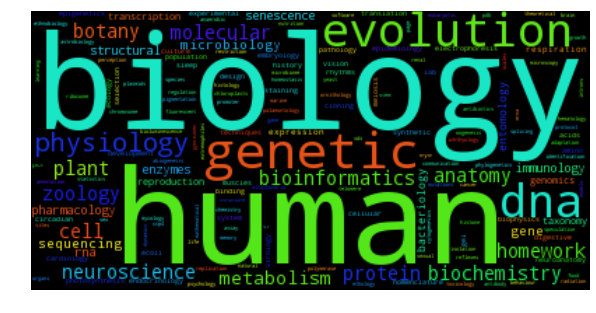

In [377]:
print("Biology!")
tag_wordcloud(balanced_classes_data.loc[balanced_classes_data['thread']=='biology'])
plt.axis("off")

Cooking!


(-0.5, 399.5, 199.5, -0.5)

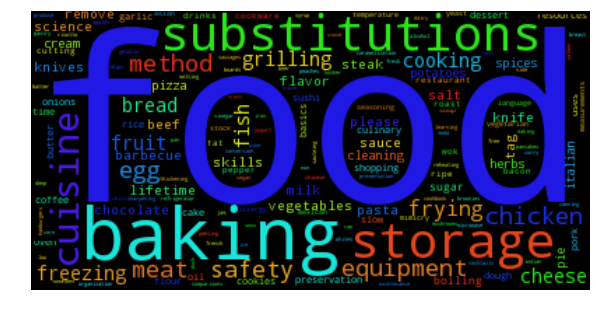

In [378]:
print("Cooking!")
tag_wordcloud(balanced_classes_data.loc[balanced_classes_data['thread']=='cooking'])
plt.axis("off")

Cryptology!


(-0.5, 399.5, 199.5, -0.5)

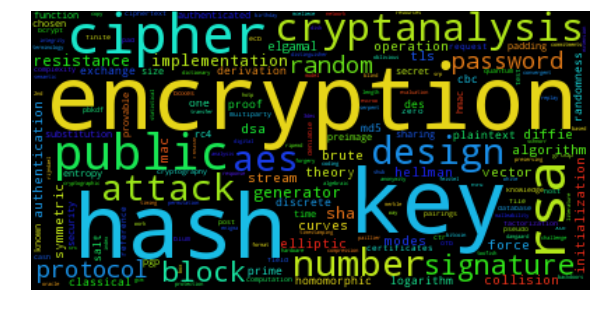

In [379]:
print("Cryptology!")
tag_wordcloud(balanced_classes_data.loc[balanced_classes_data['thread']=='crypto'])
plt.axis("off")

DIY crafts and such!


(-0.5, 399.5, 199.5, -0.5)

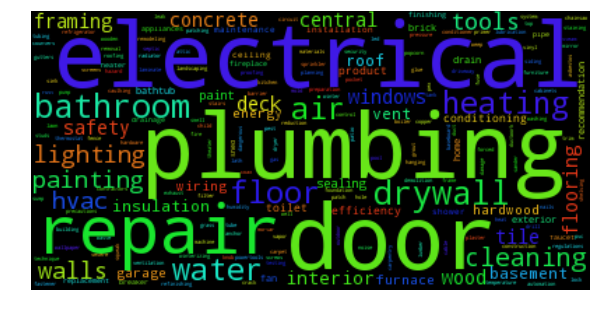

In [380]:
print("DIY crafts and such!")
tag_wordcloud(balanced_classes_data.loc[balanced_classes_data['thread']=='diy'])
plt.axis("off")

Robotics!


(-0.5, 399.5, 199.5, -0.5)

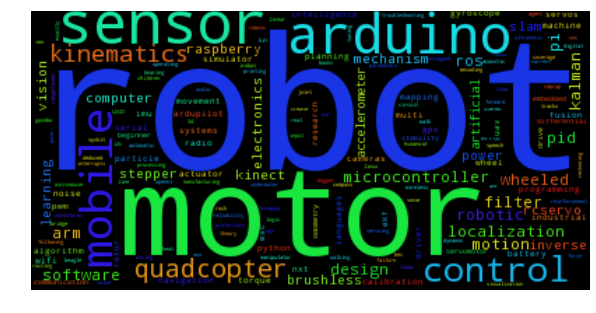

In [381]:
print("Robotics!")
tag_wordcloud(balanced_classes_data.loc[balanced_classes_data['thread']=='robotics'])
plt.axis("off")

Travel!


(-0.5, 399.5, 199.5, -0.5)

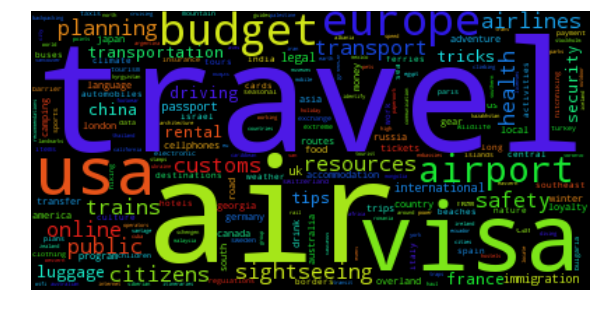

In [382]:
print("Travel!")
tag_wordcloud(balanced_classes_data.loc[balanced_classes_data['thread']=='travel'])
plt.axis("off")

### POS?

In [88]:
import spacy
nlp = spacy.en.English()
def get_pos(text):
    spacy_text = nlp(text)
    pos_tags = [token.pos_ for token in spacy_text]
    return pos_tags

In [90]:
balanced_classes_data['title_pos_list'] = balanced_classes_data.loc[:,'title'].apply(lambda x: get_pos(x))

balanced_classes_data['content_pos_list'] = balanced_classes_data.loc[:,'content'].apply(lambda x: get_pos(x))

In [205]:
def plot_pos_freq(dataframe, title):
    pos1 = np.hstack(dataframe['title_pos_list'])
    pos2 = np.hstack(dataframe['content_pos_list'])
    pos = np.hstack((pos1,pos2))
    pos_counter = dict(Counter(pos))
    pos_df = pd.DataFrame.from_dict(pos_counter, orient='index')
    pos_df.reset_index()
    pos_df.columns=['count']
    
    sns.barplot(x=pos_df.index.values, y=np.hstack(pos_df.values), orient="v")
    plt.xticks(rotation=90)
    plt.title(title)

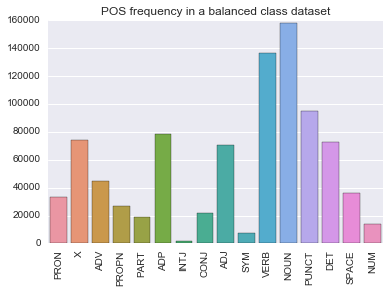

In [207]:
plot_pos_freq(balanced_classes_data, 'POS frequency in a balanced class dataset')

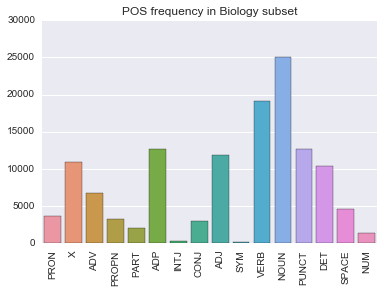

In [208]:
plot_pos_freq(balanced_classes_data.loc[balanced_classes_data['thread']=='biology'], 'POS frequency in Biology subset')

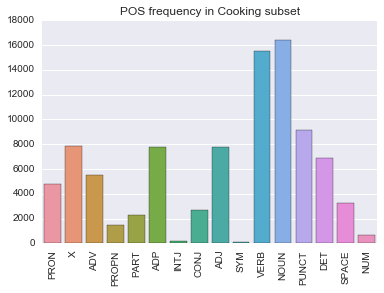

In [209]:
plot_pos_freq(balanced_classes_data.loc[balanced_classes_data['thread']=='cooking'], 'POS frequency in Cooking subset')

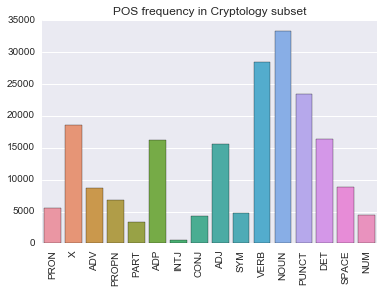

In [210]:
plot_pos_freq(balanced_classes_data.loc[balanced_classes_data['thread']=='crypto'], 'POS frequency in Cryptology subset')

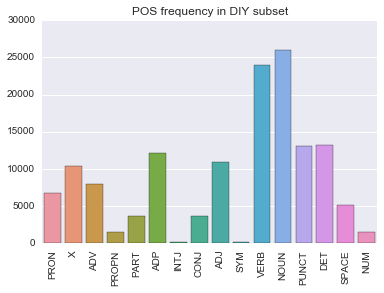

In [211]:
plot_pos_freq(balanced_classes_data.loc[balanced_classes_data['thread']=='diy'], 'POS frequency in DIY subset')

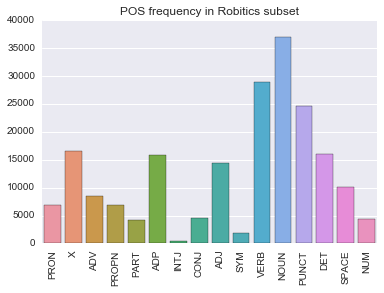

In [212]:
plot_pos_freq(balanced_classes_data.loc[balanced_classes_data['thread']=='robotics'], 'POS frequency in Robitics subset')

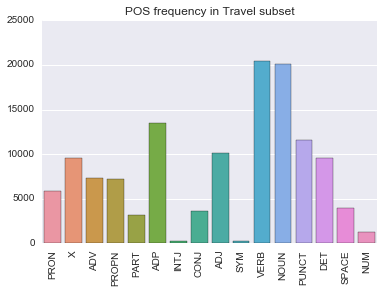

In [213]:
plot_pos_freq(balanced_classes_data.loc[balanced_classes_data['thread']=='travel'], 'POS frequency in Travel subset')

### *Travel has a greater proportion of verbs to nouns than the other thread*

In [257]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's explore tag use and similarity in hyperspace using Doc2Vec and TSNE

In [258]:
from tsne_viz import *
from gensim_modeling import *

### First, train Doc2Vec on balanced class data

In [152]:
d2v_balanced_classes_data = Doc2Vec(balanced_classes_data)

In [268]:
# store the model to mmap-able files
d2v_balanced_classes_data.save('doc2vec_models/balanced.doc2vec')

In [340]:
d2v_balanced_classes_data.similar_by_word('robot')

[('device', 0.6504671573638916),
 ('camera', 0.6478779911994934),
 ('stamp', 0.6008495092391968),
 ('vehicle', 0.595268726348877),
 ('website', 0.5764975547790527),
 ('mistake', 0.573994517326355),
 ('quadcopter', 0.5722554922103882),
 ('specs', 0.5673105120658875),
 ('seed', 0.5647504329681396),
 ('system', 0.5644040107727051)]

In [343]:
d2v_balanced_classes_data.similar_by_word('DNA')

[('SSL', 0.6026118993759155),
 ('cribs', 0.5980318784713745),
 ('Korea', 0.5817306041717529),
 ('conversion', 0.5744444131851196),
 ('Melbourne', 0.5650713443756104),
 ('Russia', 0.5643692016601562),
 ('Java', 0.5574426651000977),
 ('London', 0.5505803823471069),
 ('ROS', 0.5504175424575806),
 ('Australia', 0.54688960313797)]

### Get the average coordinate set for each document

In [194]:
tag_sentences = balanced_classes_data.tags.iloc[:].apply(lambda x: cleanText(' '.join(x)))
d2v_avg_embeddings = getAvgFeatureVecs(tag_sentences.values, d2v_balanced_classes_data, 300)

### Train TSNE

In [218]:
tsne_balanced_classes_data = tsne_object(balanced_classes_data,d2v_avg_embeddings)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 20.4630996, gradient norm = 0.0501650
[t-SNE] Iteration 50: error = 20.0354471, gradient norm = 0.0470618
[t-SNE] Iteration 75: error = 17.5053840, gradient norm = 0.0486289
[t-SNE] Iteration 100: error = 17.7019264, gradient norm = 0.0470089
[t-SNE] KL divergence after 100 iterations with early exaggeration: 17.701926
[t-SNE] Iteration 125: error = 2.1158218, gradient norm = 0.0023271
[t-SNE] Iteration 150: error = 2.0225206, gradient norm = 0.0015493
[t-SNE] Iteration 175: error = 2.0013412, gradie

### Plot TSNE Vector

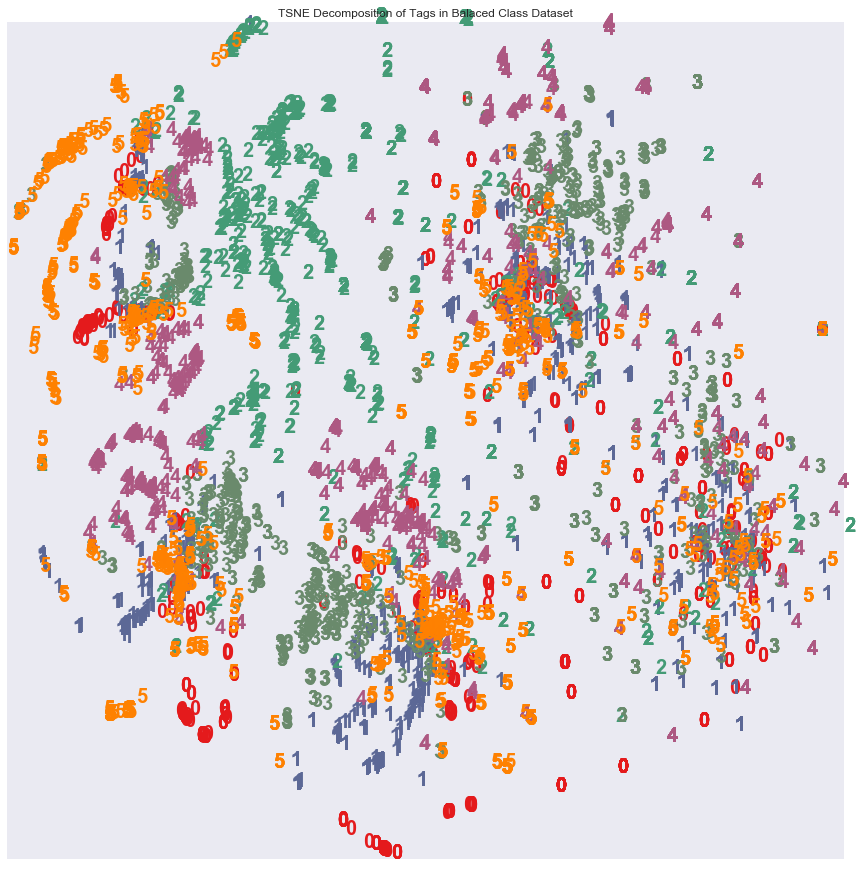

In [238]:
balanced_class_tsne_vec = tsne_balanced_classes_data.tsne_vec

def plot_embedding(X, dataframe, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(dataframe.thread_ids.values[i]),
                 color=plt.cm.Set1(dataframe.thread_ids.values[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 20})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
plot_embedding(balanced_class_tsne_vec, balanced_classes_data, "TSNE Decomposition of Tags in Balaced Class Dataset")

In [240]:
thread_dict

{'biology': 0, 'cooking': 1, 'crypto': 2, 'diy': 3, 'robotics': 4, 'travel': 5}

### Biology is packed with technical and specific language, Travel is more general. 
**Lets train seperate Doc2Vec models on larger subsets of the two threads and visualize their embedding space with TSNE**

In [248]:
!ls pickle_jar/dataframes/

allthreads_first1000.p
allthreads_first1000_data.p
allthreads_first1000_minimal_processing_data.p
bio_10000_dl_dataframe.p
biology_dataframe.p
classify_Stopwords_3xTitle_Noner_stripPunct_dataframe.p
classify_Stopwords_3xTitle_ner_stripPunct_dataframe.p
classify_Stopwords_3xTitle_ner_stripPunct_lemmatize_dataframe.p
classify_noStopwords_3xTitle_Noner_stripPunct_dataframe.p
classify_noStopwords_3xTitle_Noner_stripPunct_lemmatize_dataframe.p
classify_noStopwords_3xTitle_ner_stripPunct_dataframe.p
classify_noStopwords_3xTitle_ner_stripPunct_lemmatize_dataframe.p
travel_10000_dl_dataframe.p
travel_dataframe.p


In [255]:
"""Load in Biology Data"""
#http://stackoverflow.com/questions/24791987/why-do-i-get-pickle-eoferror-ran-out-of-input-reading-an-empty-file
import os

biology_data = {} # scores is an empty dict already

if os.path.getsize("pickle_jar/dataframes/bio_10000_dl_dataframe.p") > 0:      
    with open("pickle_jar/dataframes/bio_10000_dl_dataframe.p", "rb") as file:
        unpickler = pickle.Unpickler(file)
        biology_data = unpickler.load() # if file is not empty scores will be equal to t

biology_tag_counter_file = open('pickle_jar/tag_counters/bio_10000_dl_tag_counts.p', 'rb')
biology_classes_tag_counter = pickle.load(biology_tag_counter_file)

biology_bow_counter_file = open('pickle_jar/post_counters/bio_10000_dl_token_counts.p', 'rb')
biology_bow_counter = pickle.load(biology_bow_counter_file)


thread_dict = {'biology':0,'cooking':1,'crypto':2,'diy':3,'robotics':4,'travel':5}
biology_data['thread_ids'] = biology_data.thread.apply(lambda x: thread_dict[x]).values

### Train Doc2Vec on Biology data

In [262]:
biology_data['ttl_ctxt'] = biology_data['ttl_ctxt'].apply(lambda x: ' '.join(x))

In [263]:
d2v_biology = Doc2Vec(biology_data)

In [267]:
# store the model to mmap-able files
d2v_biology.save('doc2vec_models/bio.doc2vec')



In [344]:
d2v_biology.similar_by_word('DNA')

[('RNA', 0.6519902944564819),
 ('mRNA', 0.5565643906593323),
 ('cDNA', 0.5044240951538086),
 ('genomic', 0.4976475238800049),
 ('plasmid', 0.4907393753528595),
 ('peptide', 0.4833197593688965),
 ('pol', 0.47751131653785706),
 ('rRNA', 0.4728826582431793),
 ('protein', 0.46852999925613403),
 ('sequence', 0.4669254720211029)]

In [346]:
d2v_biology.similar_by_word('patient')

[('child', 0.7135355472564697),
 ('baby', 0.7105703353881836),
 ('woman', 0.689277172088623),
 ('person', 0.6795716285705566),
 ('leopard', 0.6790974140167236),
 ('hospital', 0.6789930462837219),
 ('cockroach', 0.6780717372894287),
 ('beach', 0.6633082032203674),
 ('suggestion', 0.6582115888595581),
 ('recipient', 0.6514725089073181)]

### Retrieve embeding

In [264]:
bio_tag_sentences = biology_data.tags.iloc[:].apply(lambda x: cleanText(' '.join(x)))
bio_d2v_avg_embeddings = getAvgFeatureVecs(bio_tag_sentences.values, d2v_biology, 300)

## Train TSNE on Biology

In [265]:
tsne_bio = tsne_object(biology_data,bio_d2v_avg_embeddings)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 21.2813266, gradient norm = 0.0143510
[t-SNE] Iteration 50: error = 20.6559659, gradient norm = 0.0167340
[t-SNE] Iteration 75: error = 17.8935422, gradient norm = 0.0144478
[t-SNE] Iteration 100: error = 17.4443941, gradient norm

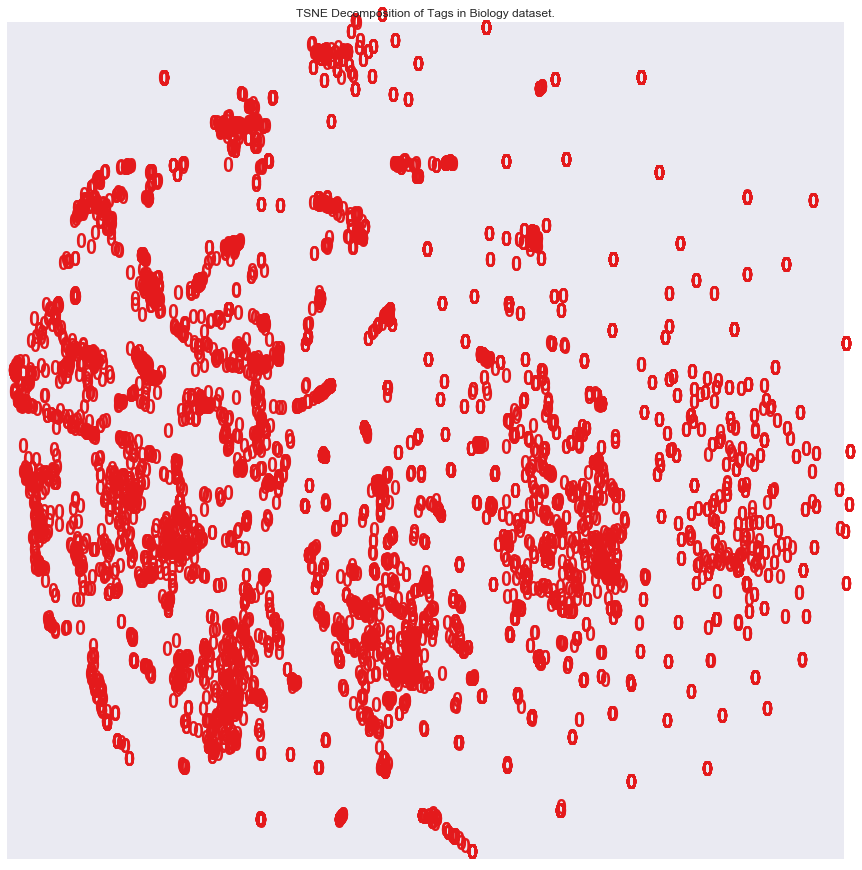

In [266]:
plot_embedding(tsne_bio.tsne_vec, biology_data, title="TSNE Decomposition of Tags in Biology dataset.")

## Travel

In [302]:
"""Load in Travel Data"""
#http://stackoverflow.com/questions/24791987/why-do-i-get-pickle-eoferror-ran-out-of-input-reading-an-empty-file
import os

travel_data = {} # scores is an empty dict already

if os.path.getsize("pickle_jar/dataframes/travel_10000_dl_dataframe.p") > 0:      
    with open("pickle_jar/dataframes/travel_10000_dl_dataframe.p", "rb") as file:
        unpickler = pickle.Unpickler(file)
        travel_data = unpickler.load() # if file is not empty scores will be equal to t

travel_tag_counter_file = open('pickle_jar/tag_counters/travel_10000_dl_tag_counts.p', 'rb')
travel_classes_tag_counter = pickle.load(travel_tag_counter_file)

travel_bow_counter_file = open('pickle_jar/post_counters/travel_10000_dl_token_counts.p', 'rb')
travel_bow_counter = pickle.load(travel_bow_counter_file)


thread_dict = {'biology':0,'cooking':1,'crypto':2,'diy':3,'robotics':4,'travel':5}
travel_data['thread_ids'] = travel_data.thread.apply(lambda x: thread_dict[x]).values

## Train Doc2Vec on Travel Data

In [295]:
#travel_data['ttl_ctxt'] = travel_data['ttl_ctxt'].apply(lambda x: ''.join(x))

In [303]:
d2v_travel = Doc2Vec(travel_data)

In [305]:
# store the model to mmap-able files
d2v_travel.save('doc2vec_models/travel.doc2vec')


In [347]:
d2v_travel.similar_by_word('visa')

[('Visa', 0.7259507179260254),
 ('visas', 0.582661509513855),
 ('attraction', 0.5626312494277954),
 ('traps', 0.5599147081375122),
 ('permit', 0.4493870139122009),
 ('ESTA', 0.4436478316783905),
 ('VISA', 0.43630924820899963),
 ('permission', 0.4074140787124634),
 ('DATV', 0.4044119417667389),
 ('phone', 0.39111554622650146)]

In [351]:
d2v_travel.similar_by_word('stress')

[('remove', 0.6660228967666626),
 ('heat', 0.6496341228485107),
 ('tends', 0.648284375667572),
 ('relax', 0.6461790800094604),
 ('teach', 0.6401318311691284),
 ('referred', 0.6387993693351746),
 ('gare', 0.633414626121521),
 ('explore', 0.6299831867218018),
 ('replies', 0.6295169591903687),
 ('berth', 0.6254100799560547)]

## Retrieve Embedding

In [306]:
travel_tag_sentences = travel_data.tags.iloc[:].apply(lambda x: cleanText(' '.join(x)))
travel_d2v_avg_embeddings = getAvgFeatureVecs(travel_tag_sentences.values, d2v_travel, 300)

## Train TSNE on Travel

In [300]:
tsne_travel = tsne_object(travel_data,travel_d2v_avg_embeddings)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 22.2046856, gradient norm = 0.0191429
[t-SNE] Iteration 50: error = 21.6911901, gradient norm = 0.0216714
[t-SNE] Iteration 75: error = 18.9245972, gradient norm = 0.0174689
[t-SNE] Iteration 100: error = 18.6341618, gradient norm

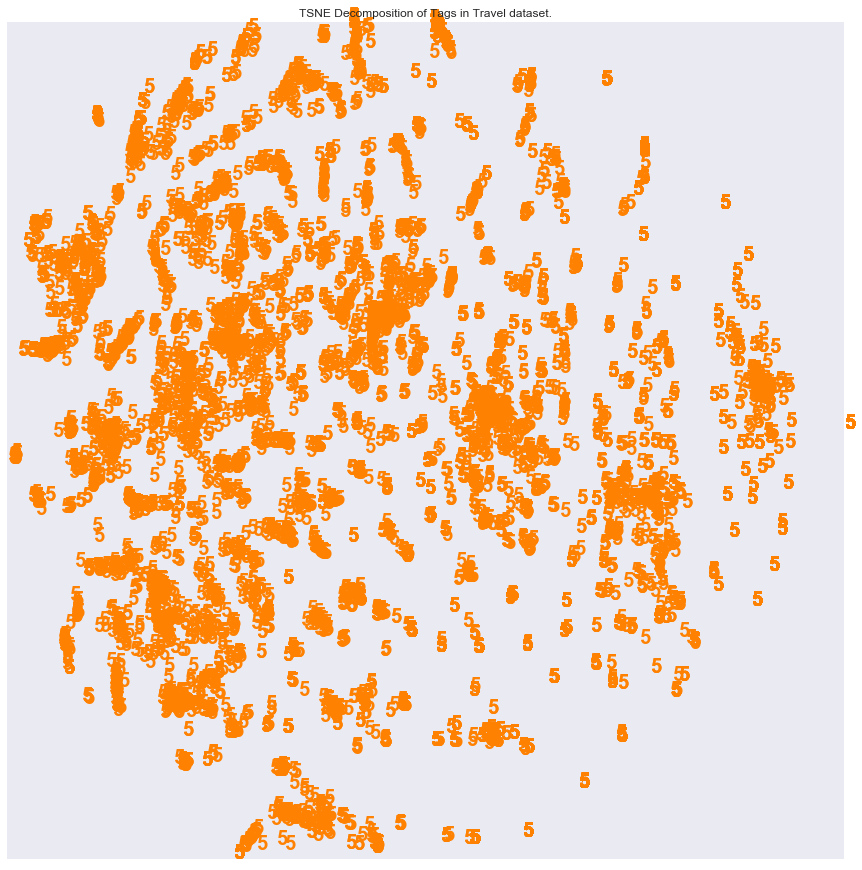

In [307]:
plot_embedding(tsne_travel.tsne_vec, travel_data, title="TSNE Decomposition of Tags in Travel dataset.")

### Next: Look at clusters with pyLDAvis

In [308]:
balanced_classes_data.to_csv('balanced_classes.csv')
travel_data.to_csv('travel.csv')
biology_data.to_csv('biology.csv')